In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import tensorflow
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
import cv2
import time

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")

In [3]:
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
train_covid_path="E:/datasets/Covid_19_dataset/train/covid/"
train_normal_path="E:/datasets/Covid_19_dataset/train/normal/"
train_pneumonia_path="E:/datasets/Covid_19_dataset/train/pneumonia/"

valid_covid_path="E:/datasets/Covid_19_dataset/validate/covid/"
valid_normal_path="E:/datasets/Covid_19_dataset/validate/normal/"
valid_pneumonia_path="E:/datasets/Covid_19_dataset/validate/pneumonia/"

train_covid_image=os.listdir(train_covid_path)
train_normal_image=os.listdir(train_normal_path)
train_pneumonia_image=os.listdir(train_pneumonia_path)

valid_covid_image=os.listdir(valid_covid_path)
valid_normal_image=os.listdir(valid_normal_path)
valid_pneumonia_image=os.listdir(valid_pneumonia_path)

print("Number of Covid Images in Training= ",len(train_covid_image))
print("Number of Normal Images in Training= ",len(train_normal_image ))
print("Number of Pneumonia Images in Training= ",len(train_pneumonia_image ))

print('\n')
print("Number of Covid Images in Validation= ",len(valid_covid_image))
print("Number of Normal Images in Validation= ",len(valid_normal_image))
print("Number of Pneumonia Images in Validation= ",len(valid_pneumonia_image))

test_path="E:/datasets/Covid_19_dataset/test"

test_covid_path="E:/datasets/Covid_19_dataset/test/covid/"
test_normal_path="E:/datasets/Covid_19_dataset/test/covid/"
test_pneumonia_path="E:/datasets/Covid_19_dataset/test/covid/"

test_covid_image=os.listdir(test_covid_path)
test_normal_image=os.listdir(test_normal_path)
test_pneumonia_image=os.listdir(test_pneumonia_path)

print('\n')
print("Number of Covid Images in Test= ",len(test_covid_image))
print("Number of Normal Images in Test= ",len(test_normal_image ))
print("Number of Pneumonia Images in Test= ",len(test_pneumonia_image ))

Number of Covid Images in Training=  2023
Number of Normal Images in Training=  5707
Number of Pneumonia Images in Training=  753


Number of Covid Images in Validation=  869
Number of Normal Images in Validation=  3761
Number of Pneumonia Images in Validation=  323


Number of Covid Images in Test=  724
Number of Normal Images in Test=  724
Number of Pneumonia Images in Test=  724


In [14]:
data_dict = {
    
}
data_dict['covid']=int(len(test_covid_image) + len(valid_covid_image) + len(test_covid_image))
data_dict['normal']=int(len(test_normal_image) + len(valid_normal_image) + len(test_normal_image))
data_dict['pneumonia']=int(len(test_pneumonia_image) + len(valid_pneumonia_image) + len(test_pneumonia_image))
print(data_dict)

{'covid': 2317, 'normal': 5209, 'pneumonia': 1771}


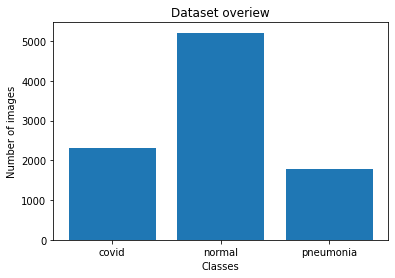

In [17]:
#plot bar graph
plt.bar(data_dict.keys(), data_dict.values())
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.title("Dataset overiew")
plt.show()

In [8]:
base_model2=tf.keras.applications.InceptionResNetV2(weights='imagenet',include_top=False)
# Design new model
x=base_model2.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)

preds = tf.keras.layers.Dense(3, activation = 'softmax')(x)  # This layer will have output. So It will have only three neurons

incep_model=tf.keras.models.Model(inputs = base_model2.input, outputs = preds)
opt=tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
incep_model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

In [9]:
for i,layer in enumerate(incep_model.layers):
  print(i,layer.name)

0 input_2
1 conv2d_203
2 batch_normalization_203
3 activation_203
4 conv2d_204
5 batch_normalization_204
6 activation_204
7 conv2d_205
8 batch_normalization_205
9 activation_205
10 max_pooling2d_4
11 conv2d_206
12 batch_normalization_206
13 activation_206
14 conv2d_207
15 batch_normalization_207
16 activation_207
17 max_pooling2d_5
18 conv2d_211
19 batch_normalization_211
20 activation_211
21 conv2d_209
22 conv2d_212
23 batch_normalization_209
24 batch_normalization_212
25 activation_209
26 activation_212
27 average_pooling2d_1
28 conv2d_208
29 conv2d_210
30 conv2d_213
31 conv2d_214
32 batch_normalization_208
33 batch_normalization_210
34 batch_normalization_213
35 batch_normalization_214
36 activation_208
37 activation_210
38 activation_213
39 activation_214
40 mixed_5b
41 conv2d_218
42 batch_normalization_218
43 activation_218
44 conv2d_216
45 conv2d_219
46 batch_normalization_216
47 batch_normalization_219
48 activation_216
49 activation_219
50 conv2d_215
51 conv2d_217
52 conv2d_220

In [10]:
for layer in incep_model.layers[:780]:
  layer.trainable=False
for layer in incep_model.layers[780:]:
  layer.trainable=True

In [6]:
# prepare Training data

train_generator=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
train_data=train_generator.flow_from_directory("E:/datasets/Covid_19_dataset/train",target_size=(299,299),class_mode='categorical', batch_size=8, shuffle=True)

Found 8483 images belonging to 3 classes.


In [7]:
len(train_data)

1061

In [22]:
# prepare Validation data

valid_generator=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
valid_data=valid_generator.flow_from_directory("E:/datasets/Covid_19_dataset/validate",target_size=(299,299),class_mode='categorical',shuffle=True,batch_size=8)

Found 4953 images belonging to 3 classes.


In [23]:
train_data.class_indices

{'covid': 0, 'normal': 1, 'pneumonia': 2}

In [25]:
hist=incep_model.fit_generator(train_data, epochs=5,validation_data=valid_data,use_multiprocessing=False, shuffle=False, workers=1)

Epoch 1/5


C:\Users\CHAITA~1\AppData\Local\Temp/ipykernel_7072/2158365058.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=incep_model.fit_generator(train_data, epochs=5,validation_data=valid_data,use_multiprocessing=False, shuffle=False, workers=1)


1061/1061 [==============================] - 302s 283ms/step - loss: 0.2775 - accuracy: 0.8970 - val_loss: 0.1355 - val_accuracy: 0.9542
Epoch 2/5
1061/1061 [==============================] - 308s 290ms/step - loss: 0.1318 - accuracy: 0.9596 - val_loss: 0.1378 - val_accuracy: 0.9582
Epoch 3/5
1061/1061 [==============================] - 307s 289ms/step - loss: 0.0673 - accuracy: 0.9775 - val_loss: 0.5711 - val_accuracy: 0.9116
Epoch 4/5
1061/1061 [==============================] - 311s 293ms/step - loss: 0.0803 - accuracy: 0.9770 - val_loss: 0.1605 - val_accuracy: 0.9406
Epoch 5/5
1061/1061 [==============================] - 307s 289ms/step - loss: 0.0522 - accuracy: 0.9835 - val_loss: 0.1065 - val_accuracy: 0.9707


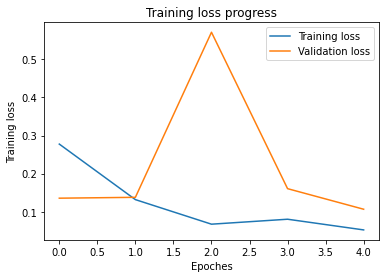

In [26]:
plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.xlabel("Epoches")
plt.ylabel("Training loss")
plt.title("Training loss progress")
plt.legend()

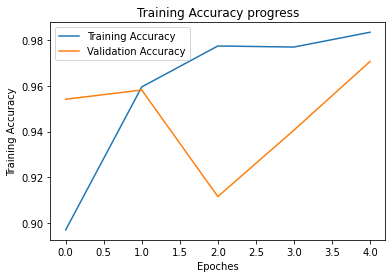

In [27]:
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoches")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy progress")
plt.legend()

In [30]:
# prepare Training data

train_generator=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
train_data=train_generator.flow_from_directory("E:/datasets/Covid_19_dataset/train",target_size=(299,299),class_mode='categorical', batch_size=32, shuffle=False)

Found 8483 images belonging to 3 classes.


In [31]:
train_data.classes

array([0, 0, 0, ..., 2, 2, 2])

In [34]:
# Training Data
actual_train_class=train_data.classes
actual_valid_class=valid_data.classes
from sklearn.metrics import confusion_matrix
train_data.reset()
y_train_pred = incep_model.predict(train_data)
y_train_pred =np.argmax(y_train_pred, axis=1)


0.9917482022869268

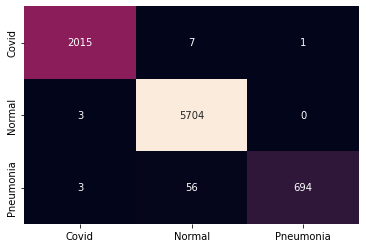

In [35]:
cm = confusion_matrix(actual_train_class, y_train_pred)
sns.heatmap(cm, annot=True,fmt='d', xticklabels=['Covid','Normal','Pneumonia'], yticklabels=['Covid','Normal','Pneumonia'],cbar=False)
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(actual_train_class, y_train_pred)

In [36]:
print(classification_report(actual_train_class, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2023
           1       0.99      1.00      0.99      5707
           2       1.00      0.92      0.96       753

    accuracy                           0.99      8483
   macro avg       0.99      0.97      0.98      8483
weighted avg       0.99      0.99      0.99      8483



In [37]:
print(incep_model.evaluate(valid_data))

620/620 [==============================] - 52s 83ms/step - loss: 0.1065 - accuracy: 0.9707
[0.10651744157075882, 0.9707248210906982]


In [38]:
# prepare Validation data

valid_generator=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
valid_data=valid_generator.flow_from_directory("E:/datasets/Covid_19_dataset/validate",target_size=(299,299),class_mode='categorical',shuffle=False,batch_size=32)

Found 4953 images belonging to 3 classes.


<AxesSubplot:>

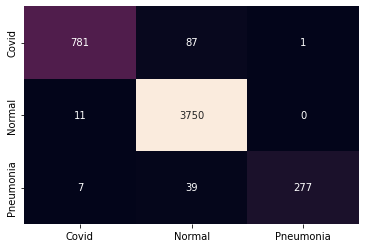

In [39]:
# Validation Data

from sklearn.metrics import confusion_matrix

y_valid_pred = incep_model.predict(valid_data)
y_valid_pred =np.argmax(y_valid_pred, axis=1)

cm = confusion_matrix(actual_valid_class, y_valid_pred)
sns.heatmap(cm, annot=True,fmt='d', xticklabels=['Covid','Normal','Pneumonia'], yticklabels=['Covid','Normal','Pneumonia'],cbar=False)

In [40]:
print(accuracy_score(actual_valid_class, y_valid_pred))
print(classification_report(actual_valid_class, y_valid_pred))

0.9707248132444983
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       869
           1       0.97      1.00      0.98      3761
           2       1.00      0.86      0.92       323

    accuracy                           0.97      4953
   macro avg       0.98      0.92      0.95      4953
weighted avg       0.97      0.97      0.97      4953



In [41]:
# test Data

test_generator=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
test_data=test_generator.flow_from_directory("E:/datasets/Covid_19_dataset/test",target_size=(299,299),class_mode='categorical', batch_size=32, shuffle=False)


Found 1717 images belonging to 3 classes.


0.9569015725101921

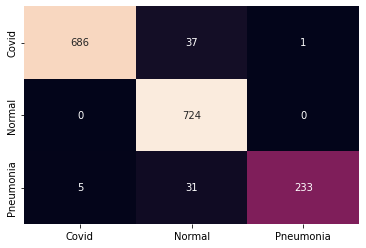

In [42]:
# Test Data
actual_test_class=test_data.classes
train_data.reset()
y_test_pred = incep_model.predict(test_data)
y_test_pred = np.argmax(y_test_pred, axis=1)
cm = confusion_matrix(actual_test_class, y_test_pred)
sns.heatmap(cm, annot=True,fmt='d', xticklabels=['Covid','Normal','Pneumonia'], yticklabels=['Covid','Normal','Pneumonia'],cbar=False)
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(actual_test_class, y_test_pred)

In [43]:
print(incep_model.evaluate(test_data))

54/54 [==============================] - 13s 225ms/step - loss: 0.1363 - accuracy: 0.9569
[0.1363382339477539, 0.9569015502929688]


In [44]:
print(accuracy_score(actual_test_class, y_test_pred))
print(classification_report(actual_test_class, y_test_pred))

0.9569015725101921
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       724
           1       0.91      1.00      0.96       724
           2       1.00      0.87      0.93       269

    accuracy                           0.96      1717
   macro avg       0.97      0.94      0.95      1717
weighted avg       0.96      0.96      0.96      1717

